Model Accuracy: 50.86%
Total number of anomalies: 242
Detected Anomalies:
             Mitigation_Suggestion Timestamp   Server_ID Resource_Utilization  \
0                  Restart Service   06:58.7  Server_103                  low   
4                  Restart Service   46:58.7  Server_107                 high   
5                              NaN   41:58.7   Server_72               medium   
7                          Monitor   31:58.7   Server_21                 high   
8                          Monitor   26:58.7  Server_615                  low   
...                            ...       ...         ...                  ...   
24994  Investigate Security Breach   16:58.8  Server_788                 high   
24996              Restart Service   06:58.8  Server_708               medium   
24997           Increase Resources   01:58.8  Server_917                  low   
24998  Investigate Security Breach   56:58.8   Server_21                 high   
24999                      Monitor 

c:\Users\Vikash Agrahari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


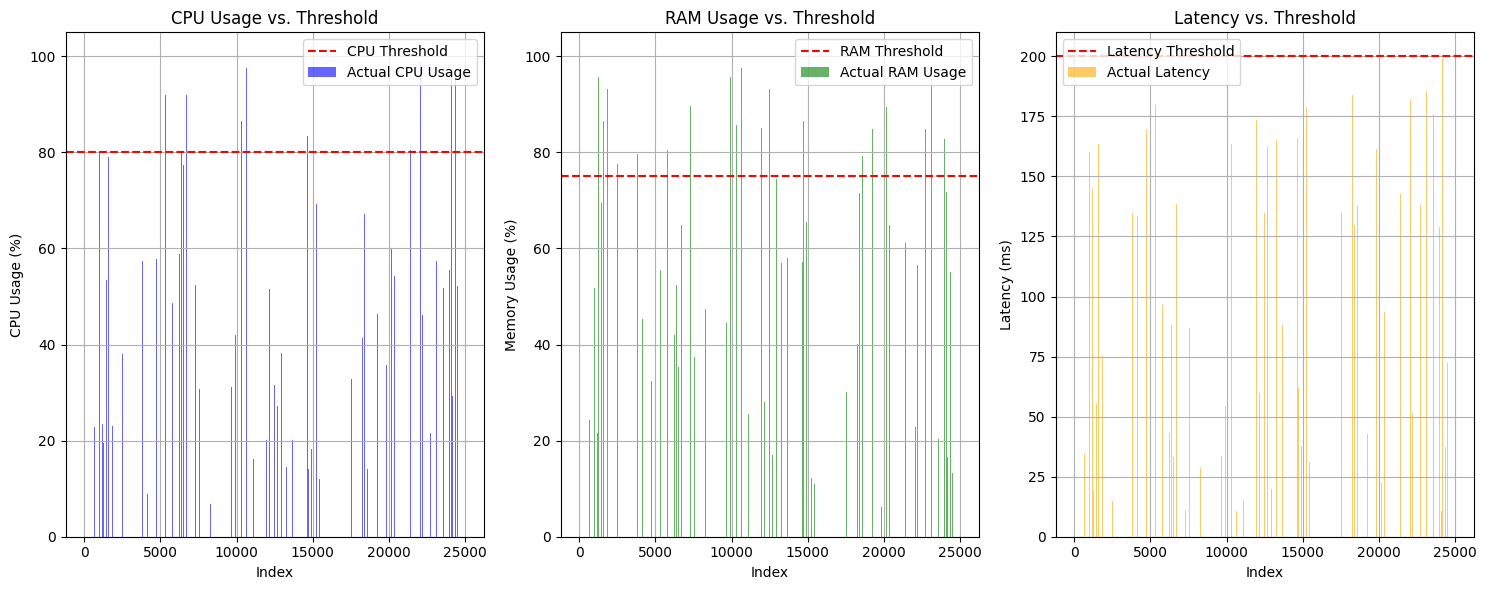

In [7]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = "cloud_infrastructure_anomaly_detection_with_ip.csv"
data = pd.read_csv(file_path)

# Step 2: Handle missing values
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Step 3: Encode 'Alert_Triggered'
data['Alert_Triggered'] = data['Alert_Triggered'].apply(lambda x: 1 if x == '1' else 0)

# Step 4: Create interaction features
data['CPU_RAM_Interaction'] = data['CPU_Usage(%)'] * data['Memory_Usage(%)']
data['Latency_per_CPU'] = data['Latency(ms)'] / (data['CPU_Usage(%)'] + 1)

# Step 5: Select relevant columns for training and testing
train_columns = [
    'CPU_Usage(%)', 'Memory_Usage(%)', 'Latency(ms)',
    'CPU_RAM_Interaction', 'Latency_per_CPU'
]

# Step 6: Split the data into 80% train and 20% test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare features and labels
X_train = train_data[train_columns]
y_train = (train_data['Anomaly_Score'] > 0.5).astype(int)

X_test = test_data[train_columns]
y_test = (test_data['Anomaly_Score'] > 0.5).astype(int)

# Step 7: Scale the data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler to ensure consistency during prediction
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Step 8: Train the Isolation Forest model
model = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
model.fit(X_train_scaled)

# Step 9: Predict on the test set
y_pred = model.predict(X_test_scaled)
y_pred_labels = (y_pred == -1).astype(int)  # Convert to 0 or 1

# Step 10: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Step 11: Save the trained model using pickle
with open("anomaly_detection_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Step 12: Calculate total anomalies in the test dataset
total_anomalies = (y_pred_labels == 1).sum()
print(f"Total number of anomalies: {total_anomalies}")

# Step 13: Display anomalies with specific columns
anomalies = data[data['Anomaly_Score'] > 0.5][[
    'Mitigation_Suggestion', 'Timestamp', 'Server_ID', 
    'Resource_Utilization', 'IP_Address'
]]
print("Detected Anomalies:")
print(anomalies)

# Step 14: Prediction function to calculate anomaly score for new input
def predict_anomaly(cpu_usage, memory_usage, latency):
    # Load the scaler and model
    with open("scaler.pkl", "rb") as f:
        scaler = pickle.load(f)

    with open("anomaly_detection_model.pkl", "rb") as f:
        model = pickle.load(f)

    # Prepare the input
    input_data = [[
        cpu_usage, memory_usage, latency,
        cpu_usage * memory_usage, latency / (cpu_usage + 1)
    ]]
    input_scaled = scaler.transform(input_data)

    # Predict anomaly score
    anomaly_score = model.decision_function(input_scaled)

    # Return anomaly status (1 for anomaly, 0 for normal)
    return 1 if anomaly_score[0] < 0 else 0

# Example usage
cpu = 850.5
ram = 700.2
latency = 150.0
anomaly_status = predict_anomaly(cpu, ram, latency)
print(f"Anomaly Status: {anomaly_status}")

# Step 15: Bar graph comparing CPU Usage and Threshold
cpu_threshold = 80.0
ram_threshold = 75.0
latency_threshold = 200.0

# Plotting
plt.figure(figsize=(15, 6))

# CPU Usage Bar Graph
plt.subplot(1, 3, 1)
plt.bar(test_data.index, test_data['CPU_Usage(%)'], label='Actual CPU Usage', color='blue', alpha=0.6)
plt.axhline(y=cpu_threshold, color='r', linestyle='--', label='CPU Threshold')
plt.title('CPU Usage vs. Threshold')
plt.xlabel('Index')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.grid()

# RAM Usage Bar Graph
plt.subplot(1, 3, 2)
plt.bar(test_data.index, test_data['Memory_Usage(%)'], label='Actual RAM Usage', color='green', alpha=0.6)
plt.axhline(y=ram_threshold, color='r', linestyle='--', label='RAM Threshold')
plt.title('RAM Usage vs. Threshold')
plt.xlabel('Index')
plt.ylabel('Memory Usage (%)')
plt.legend()
plt.grid()

# Latency Bar Graph
plt.subplot(1, 3, 3)
plt.bar(test_data.index, test_data['Latency(ms)'], label='Actual Latency', color='orange', alpha=0.6)
plt.axhline(y=latency_threshold, color='r', linestyle='--', label='Latency Threshold')
plt.title('Latency vs. Threshold')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
